# Kuramoto-Sivashinsky (KS) equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from plots import contour_plot

Ntraj_to_simulate = 25 # 25
Ntime_for_nn = 500 # 500 - working

## Generation of the data

Solving in $[0,L]$ with $L=2\pi$ for $u_0 = \cos(2 \pi\,x/L)\cdot (1+\sin(2 \pi\,x/L))$

In [2]:
N = 2**11
L = 2 * np.pi * 16

tmax = 100
dt = 1e-2
saved_steps = Ntime_for_nn

x = L * np.linspace(0, 1, N, endpoint=False)

For different values of viscosity $\nu$, we generate the data.

In [3]:
from ks import renshaw
from tqdm import tqdm
from numpy.random import default_rng

nu = np.linspace(1, 1.5, Ntraj_to_simulate)
omega = [1] # np.linspace(1, 4, 20)

Ns = len(nu) * len(omega)

bar = tqdm(range(Ns), 'Solving parametric KS equation')
snapshots_data = list()
params = list()

for _nu in nu:
    for ii in range(len(omega)):
        
        u0 = lambda x: np.cos(omega[ii] * 2 * np.pi * x / L) * (1 + np.sin(omega[ii] * 2 * np.pi * x / L))

        snapshots_data.append(renshaw(x, u0, tmax = tmax, N = N, h = dt, nu = _nu, saved_steps=saved_steps))
        params.append(np.array([_nu, omega[ii]]))
        
        bar.update(1)
        
params = np.asarray(params)

Solving parametric KS equation:   0%|          | 0/25 [00:00<?, ?it/s]

Solving parametric KS equation: 100%|██████████| 25/25 [01:07<00:00,  2.68s/it]

Let us check that the IC satisfy the following condition
\begin{equation*}
\int_0^L u_0(x)\,dx=0
\end{equation*}

In [4]:
from scipy.integrate import quad
quad(u0, 0, L)[0]

1.6741768790441432e-14

### Comparison plots and saving

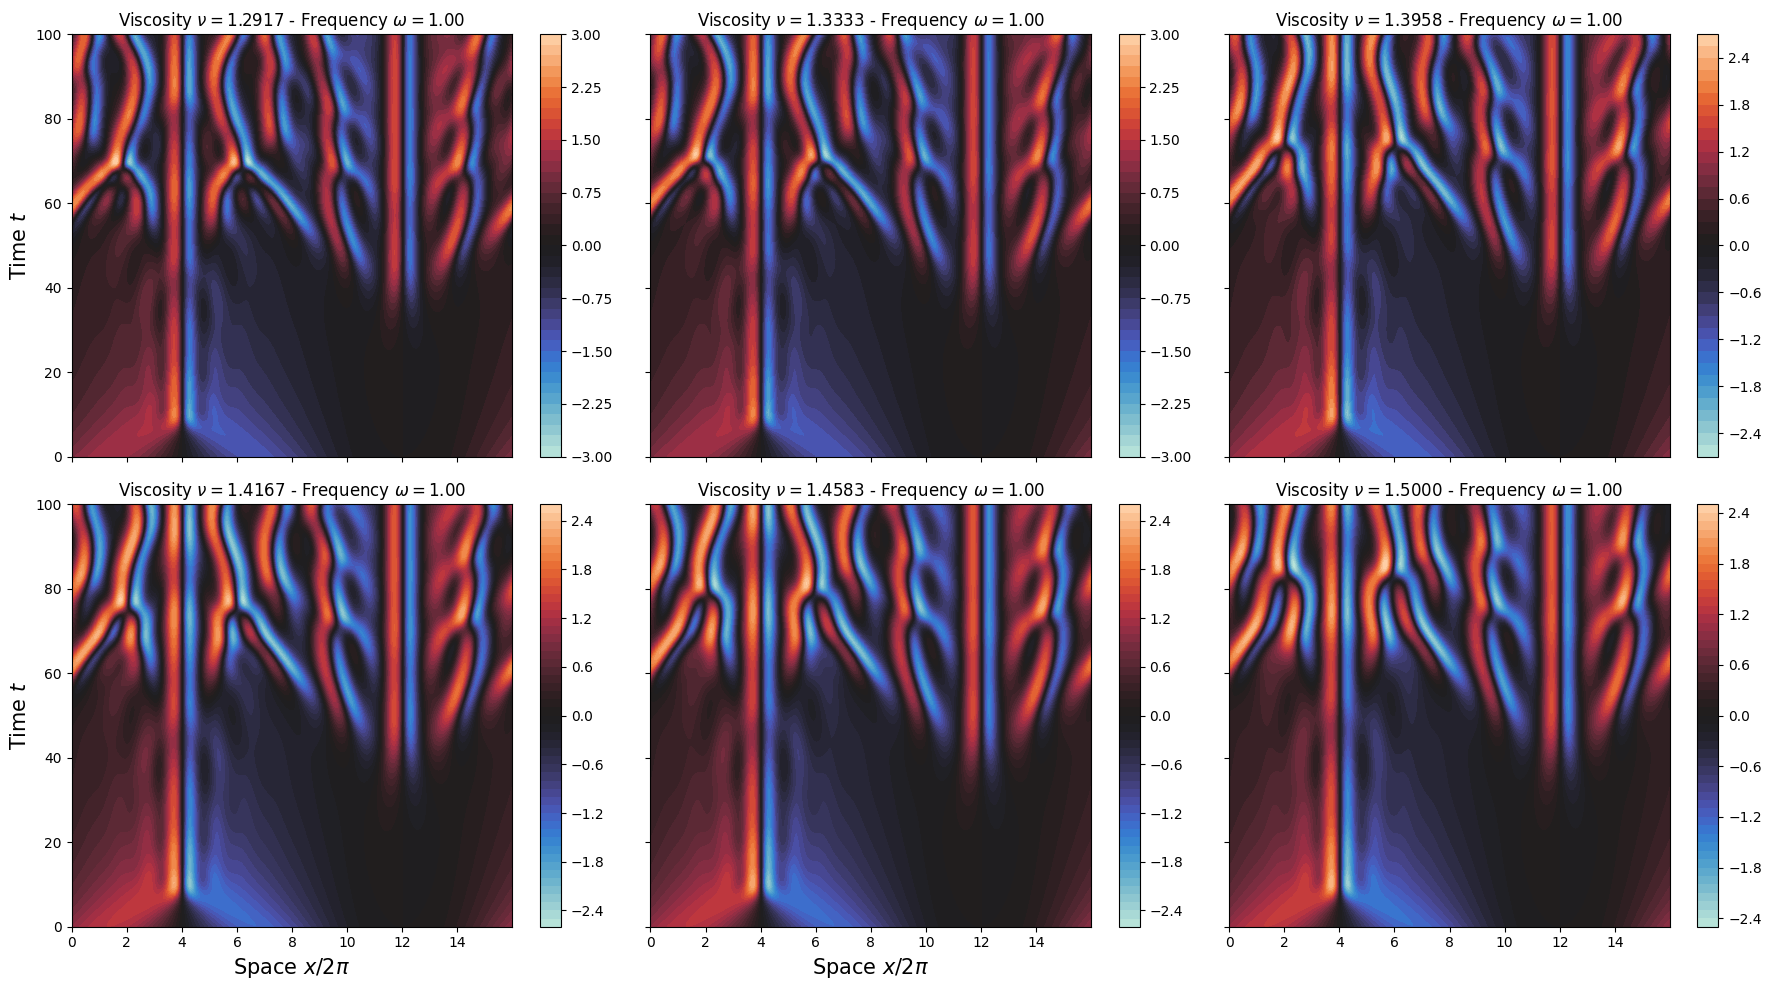

In [5]:
import seaborn as sns

nrows = 2
ncols = 3

param_to_plot = np.sort(np.random.choice(len(snapshots_data), nrows * ncols, replace=False))

fig, axs = plt.subplots(nrows, ncols, sharex = True, sharey = True, figsize=(6 * ncols, 5*nrows))

axs = axs.flatten()

levels = 50

for ii, param in enumerate(param_to_plot):
    contour_plot(axs[ii], *snapshots_data[param], 
                 title=r'Viscosity $\nu={:.4f}$'.format(params[param,0])+r' - Frequency $\omega={:.2f}$'.format(params[param,1]), 
                 levels=levels, cmap=sns.color_palette('icefire', as_cmap=True))

axs = axs.reshape(nrows, ncols)
for jj in range(nrows):
    axs[jj, 0].set_ylabel(r'Time $t$', fontsize=15)

axs[-1,0].set_xlabel(r'Space $x/2\pi$', fontsize=15)
axs[-1,1].set_xlabel(r'Space $x/2\pi$', fontsize=15)

plt.tight_layout()

Let us store the snapshots

In [6]:
import os

snaps = dict()
domain = x
snaps['t'] = snapshots_data[0][1]
snaps['params'] = params[:,0].reshape(-1,1)
snaps['snapshots'] = {'u': [snap[2].T for snap in snapshots_data]}

## Singular Value Decomposition

In [7]:
from sklearn.utils.extmath import randomized_svd
import numpy as np
from scalers import ICStdScaler, ICMinMaxScaler

rescaling_snaps = list()
var_names = ['u']
Nmodes = []

u_total = dict()
s_total = dict()

modes_number = [20]
cut_train = int(len(snaps['t']) * 1)

for field_i, field in enumerate(var_names):
    u = np.hstack([snap[:, :cut_train] for snap in snaps['snapshots'][field]])
    
    rescaling_snaps.append(ICStdScaler(u))
    
    X = rescaling_snaps[field_i].transform(u)
    
    _Nmodes = modes_number[field_i]
    
    Nmodes.append(_Nmodes)
    
    u_svd, s_svd, v_svd = randomized_svd(X, n_components = _Nmodes, n_iter = 'auto')

    if field_i == 0:
        v_total = v_svd
    else:
        v_total = np.vstack((v_total, v_svd))
        
    s_total[field] = s_svd.flatten()
    u_total[field] = u_svd
        
Nmodes = np.asarray(Nmodes)

Let us plot the sing vals

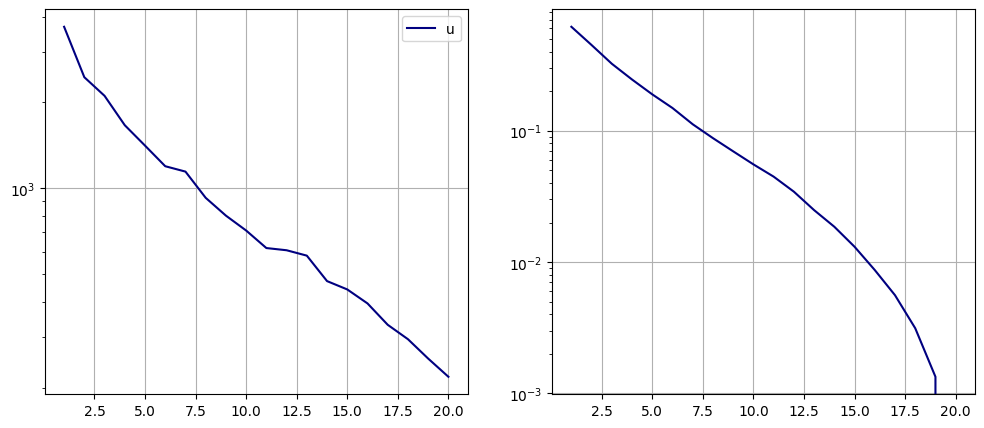

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, figsize=(12,5))

colors = cm.jet(np.linspace(0,1,len(var_names)))
for field_i, field in enumerate(var_names):
    N_plot = np.arange(1, Nmodes[field_i]+1, 1)
    axs[0].semilogy(N_plot, s_total[field], color=colors[field_i], label=field)
    axs[1].semilogy(N_plot, 1-np.cumsum(s_total[field]**2) / np.sum(s_total[field]**2), color=colors[field_i], label=field)
axs[0].grid()
axs[1].grid()
axs[0].legend()

Checking the training error

In [ ]:
print(v_total.shape)

# Check errors

for field_i in range(len(var_names)):
    field = var_names[field_i]

    true_field = np.hstack([snap[:, :cut_train] for snap in snaps['snapshots'][field]])
    rec = rescaling_snaps[field_i].inverse_transform(u_total[field] @ (np.diag(s_total[field]) @ v_total[np.sum(Nmodes[:field_i]) : np.sum(Nmodes[:field_i+1])]))

    errors = np.linalg.norm(rec - true_field, axis = 0) / np.linalg.norm(true_field, axis=0)

    print(field)
    print('   max = {:.3e}'.format(np.max(errors)) +' and ave {:.3e}'.format(np.mean(errors)))

(20, 12525)
u
   max = 1.501e-01 and ave 5.480e-02


SVD comparison plot

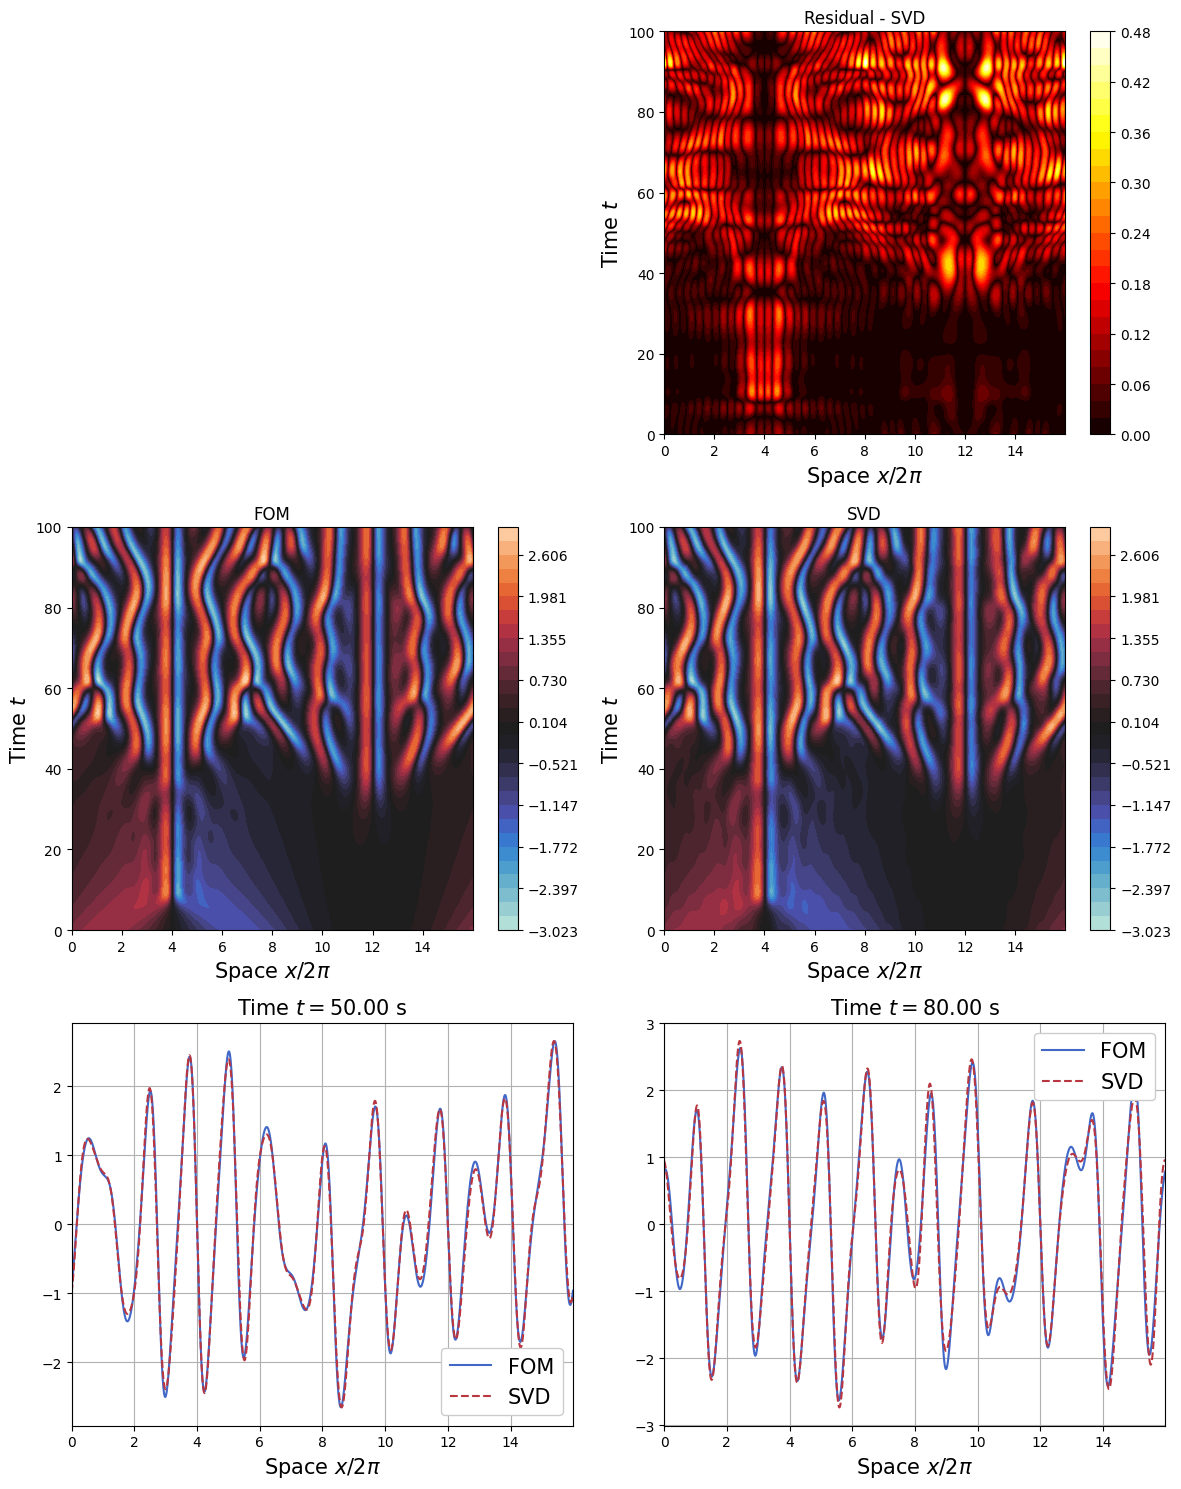

In [ ]:
from plots import plot_FOM_vs_Recon

recons = {'SVD': rescaling_snaps[field_i].inverse_transform(np.linalg.multi_dot([u_total[field], 
                                                            np.diag(s_total[field]), 
                                                            v_total[:, 0 : cut_train]]))}
plot_FOM_vs_Recon(domain, snaps['t'][:cut_train], snaps['snapshots']['u'][0][:, :cut_train], recons, time_idx = [0.5, 0.8])

Let us upscale the data

In [11]:
from scipy.interpolate import CubicSpline

r = v_total.shape[0]
t = np.asarray(snaps['t'][:cut_train])
nt = len(t)
newnt = Ntime_for_nn

new_t = np.linspace(t[0], t[-1], newnt)
v_total_new = np.zeros((r, newnt * len(snaps['params'])))

for j in range(r):
    for fold_i in range(len(snaps['params'])):
        spline = CubicSpline(t, v_total[j, fold_i * nt : (fold_i+1) * nt ])
        v_total_new[j, fold_i * newnt : (fold_i+1) * newnt] = spline(new_t)

_v_total = v_total
v_total  = v_total_new

## Compute Measures

In [12]:
measured_field = 0

from tqdm import tqdm
num_sensors = 3
sensor_locations = np.arange(0, num_sensors, 1, dtype=int) # [0,1,2]

n_configurations = 4
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)
sensors = list()

snap_measurements = np.zeros((num_sensors, len(t) * len(params), n_configurations))

np.random.seed(109) # set seed for reproducibility
for kk in tqdm(range(n_configurations), 'Creating sensors'):

    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(domain, size=num_sensors, replace=False), dtype=int)
    for param_i, snap in enumerate(snaps['snapshots'][var_names[measured_field]]):
        snap_measurements[:, param_i * len(t) : (param_i+1) * len(t), kk] = snap[idx_sensor_locations[:,kk], :cut_train]

Creating sensors: 100%|██████████| 4/4 [00:00<00:00, 766.15it/s]


Let us upscale the measuremnts

In [13]:
from scipy.interpolate import CubicSpline

noise_value = 2.5/100
Xsensor = np.zeros((num_sensors, newnt * len(params), n_configurations))

for kk in range(n_configurations):
    for j in range(num_sensors):
        
        for fold_i in range(len(params)):
            measure = snap_measurements[j, fold_i * nt : (fold_i+1) * nt, kk]
            
            spline = CubicSpline(t, measure)
            Xsensor[j, fold_i * newnt : (fold_i+1) * newnt , kk] = spline(new_t) + np.random.normal(scale=noise_value, size=new_t.shape)

Let us plot some configurations

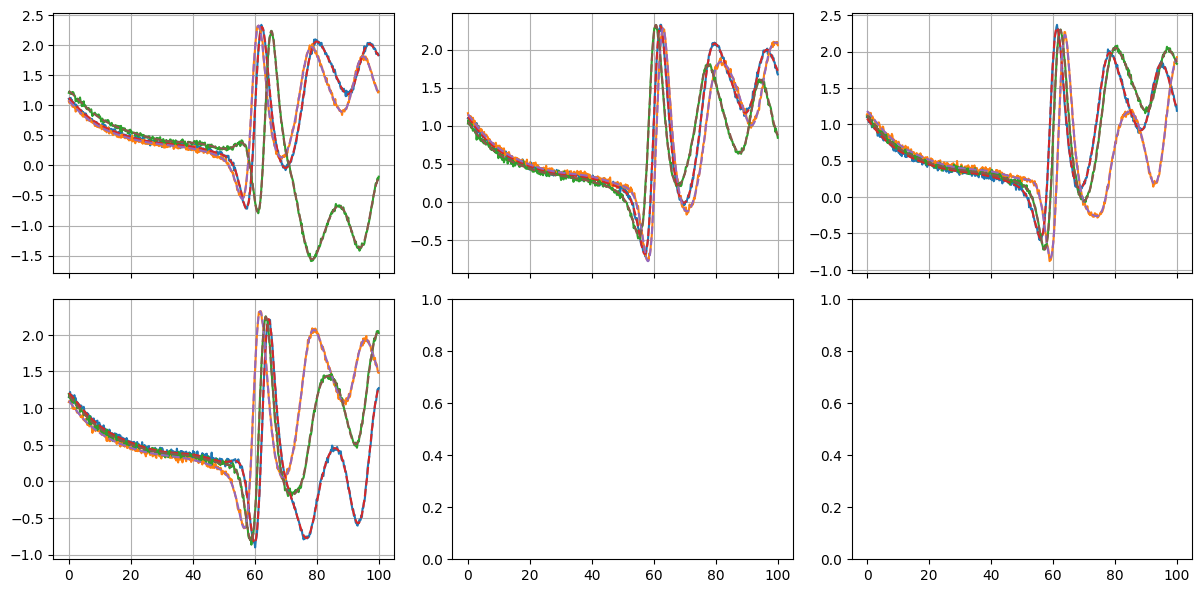

In [ ]:
ncols = 3
nrows = 2
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize= (4 * ncols, 3 * nrows))
axs = axs.flatten()

fold_i = 15

for kk in range(n_configurations):
# for kk in range(ncols * nrows):
    axs[kk].plot(new_t, Xsensor[:,fold_i * newnt : (fold_i+1) * newnt ,kk].T, label='Spline')
    axs[kk].plot(t, snap_measurements[:,fold_i * nt : (fold_i+1) * nt ,kk].T, '--', label='FOM')
    axs[kk].grid()
    
plt.tight_layout()

Let us store the measures

In [15]:
measurements = dict()
measurements['mesh'] = domain
measurements['location'] = idx_sensor_locations
measurements['point_spread'] = None
measurements['noise'] = noise_value

measurements['measured_field'] = measured_field

measurements['noisy_output'] = Xsensor

## SHRED

In [16]:
Nvariables = len(var_names)
n_configurations = measurements['location'].shape[1]
num_sensors = measurements['noisy_output'].shape[0]

assert measurements['noisy_output'].shape[2] == n_configurations

Ns = measurements['noisy_output'].shape[1]

tex_var_names = ['u']
assert len(tex_var_names) == len(var_names)

import sys

sys.path.append('../utils/')

from processdata import TimeSeriesDataset, mre
import models
import torch
from sklearn.preprocessing import MinMaxScaler
import os

path_shred = './SHRED/'
    
if not os.path.exists(path_shred):
    os.makedirs(path_shred)

Let us split the input parameters $\boldsymbol{\mu}$ (not including time $t$) into train and test

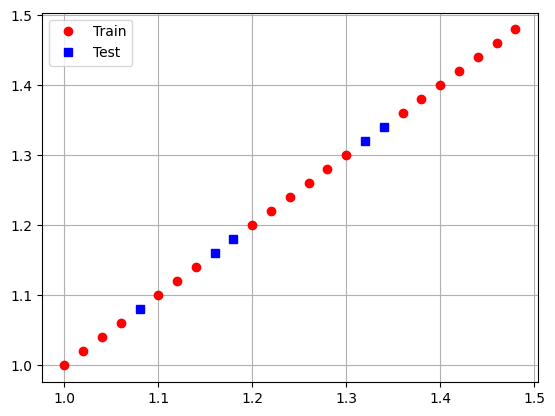

In [17]:
params = params[:,0]
Nparams = len(params)

# Always include the first and last elements in the train indices, the rest are randomly selected
train_indices_set = {0, Nparams - 1}
remaining_train_size = int(Nparams * 0.8) - len(train_indices_set)

# Set the random seed for reproducibility
np.random.seed(100)
remaining_indices = np.random.choice(
    np.arange(1, Nparams - 1), size=remaining_train_size, replace=False
)

# Combine the always-included indices with the randomly selected ones
param_train_indices = np.sort(np.array(list(train_indices_set) + list(remaining_indices)))

# Create the mask and determine validation and test indices
mask = np.ones(Nparams)
mask[param_train_indices] = 0
param_test_indices = np.arange(Nparams)[mask != 0]

plt.plot(param_train_indices, param_train_indices, 'ro', label='Train')
plt.plot(param_test_indices,  param_test_indices,  'bs', label='Test')

# Redefining xticks and yticks in the range [0.75, 1.5]
ticks = np.arange(0, len(params)+1, 5)
plt.xticks(ticks, np.round(np.linspace(min(params.flatten()), max(params.flatten()), num=len(ticks)), 2))
plt.yticks(ticks, np.round(np.linspace(min(params.flatten()), max(params.flatten()), num=len(ticks)), 2))

plt.grid()
plt.legend()

Let us create the parameter structure for SHRED

In [18]:
num_param = 1
_load_param = np.zeros((Ns, num_param))
for i in range(len(params)):
    _load_param[i * newnt : (i+1) * newnt] = params[i]

For each sensor, a SHRED model is trained

In [19]:
import pickle 

lags = 30
sensor_locations = np.arange(0, num_sensors, 1, dtype=int) # [0,1,2]

shred = list()
test_datasets = list()

train_net = True

################################################################################################################

for kk in range(n_configurations):
    
    print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

    # Creating input data
    Xsensor = measurements['noisy_output']
    load_X = np.concatenate([   
                                Xsensor[:,:,kk].T.reshape(Nparams, newnt, num_sensors), # Measures
                                _load_param.reshape(Nparams, newnt, num_param),         # Parameters
                                v_total.T.reshape(Nparams, newnt, sum(Nmodes))          # Reduced Coefficients
                            ],
                            axis = -1)[param_train_indices]

    # print(load_X.shape)

    m = load_X.shape[2]
    assert m == num_sensors + num_param + sum(Nmodes)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    shred.append(models.SHRED(num_sensors, m, 
                              hidden_size=64, hidden_layers=2, 
                              decoder_sizes = [350, 400], dropout=0.1).to(device))

    if train_net:
        
        # Reconstruction - splitting into train, test and validation
        time_train_indices = np.random.choice(newnt - lags, size=int(0.75 * newnt), replace=False)
        mask = np.ones(newnt - lags)
        mask[time_train_indices] = 0
        time_valid_test_indices = np.arange(0, newnt - lags)[np.where(mask!=0)[0]]
        time_valid_indices = time_valid_test_indices[::2]
        time_test_indices = time_valid_test_indices[1::2]
        
        # sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 
        sc = MinMaxScaler()
        sc = sc.fit(load_X.reshape(-1, m))
        
        # Generate parametric input sequences to a SHRED model (Nparam x Ntimes x Nfeatures)
        transformed_X = np.zeros(( (newnt - lags) * len(param_train_indices), lags, m))
        for mu in range(len(param_train_indices)):
            for ii in range(newnt - lags):
                transformed_X[mu * (newnt - lags) + ii] = sc.transform(load_X[mu, ii:ii+lags])
        
        _train_indices = np.array([time_train_indices + (newnt - lags) * ii for ii in range(len(param_train_indices)) ]).flatten()
        _test_indices  = np.array([time_test_indices  + (newnt - lags) * ii for ii in range(len(param_train_indices)) ]).flatten()
        _valid_indices = np.array([time_valid_indices + (newnt - lags) * ii for ii in range(len(param_train_indices)) ]).flatten()
        
        # Generate training validation and test datasets both for reconstruction of states and forecasting sensors
        train_data_in = torch.tensor(transformed_X[_train_indices, :, :num_sensors], dtype=torch.float32).to(device)
        valid_data_in = torch.tensor(transformed_X[_valid_indices, :, :num_sensors], dtype=torch.float32).to(device)
        test_data_in  = torch.tensor(transformed_X[_test_indices,  :, :num_sensors], dtype=torch.float32).to(device)

        # -1 to have output be at the same time as final sensor measurements
        train_data_out = torch.tensor(transformed_X[_train_indices, -1], dtype=torch.float32).to(device)
        valid_data_out = torch.tensor(transformed_X[_valid_indices, -1], dtype=torch.float32).to(device)
        test_data_out  = torch.tensor(transformed_X[_test_indices,  -1], dtype=torch.float32).to(device)

        train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
        valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
        test_dataset  = TimeSeriesDataset(test_data_in, test_data_out)

        ### Store the test_datasets for later use
        test_datasets.append({'X': test_dataset.X,
                            'Y': test_dataset.Y,
                            'time_idx' : {'train': time_train_indices,  'valid': time_valid_indices,  'test': time_valid_indices},
                            'param_idx': {'train': param_train_indices,                               'test': param_test_indices},
                            'full_idx' : {'train': _train_indices,      'valid': _valid_indices,      'test': _test_indices},
                            'scaler': sc})

        validation_errors = models.fit( shred[kk], train_dataset, valid_dataset, 
                                        criterion = mre,
                                        batch_size=64, epochs=3000, lr=1e-3, verbose=True, patience=10)
        
        torch.save(shred[kk].state_dict(), path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measurements['measured_field']]+'.shred')
        pickle.dump(test_datasets, open(path_shred+'datasets_measuring_'+str(num_sensors)+'.test', 'wb'))
    else:
        shred[kk].load_state_dict(torch.load(path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measurements['measured_field']]+'.shred',
                                             map_location=device))
        test_datasets = pickle.load(open(path_shred+'datasets_measuring_'+str(num_sensors)+'.test', 'rb'))
    print(' ')
if train_net:
    print('--------------------------------------------------------')
    print('SHRED training completed')
else:
    print('SHRED import completed')

 
--------------------------------------------------------
SHRED training completed


Let us check the test errors

In [20]:
path_test = './Test_results/'
    
if num_sensors != 3:
    path_test += 'Measuring_'+str(num_sensors)+'/'
    
if not os.path.exists(path_test):
    os.makedirs(path_test)  

if train_net:
    test_recons = list()
    test_ground_truth = list()

    relative_test_errors = list()

    for kk in range(n_configurations):
        test_recons.append(sc.inverse_transform(shred[kk](test_datasets[kk]['X']).detach().cpu().numpy()))
        test_ground_truth.append(sc.inverse_transform(test_datasets[kk]['Y'].detach().cpu().numpy()))
        
        relative_test_errors.append(np.linalg.norm(test_recons[kk] - test_ground_truth[kk]) / np.linalg.norm(test_ground_truth[kk]))
        
    pickle.dump([test_recons, test_ground_truth, relative_test_errors], open(path_test+'test.results', 'wb'))
else:
    test_recons, test_ground_truth, relative_test_errors = pickle.load(open(path_test+'test.results', 'rb'))

Let us plot the error bars

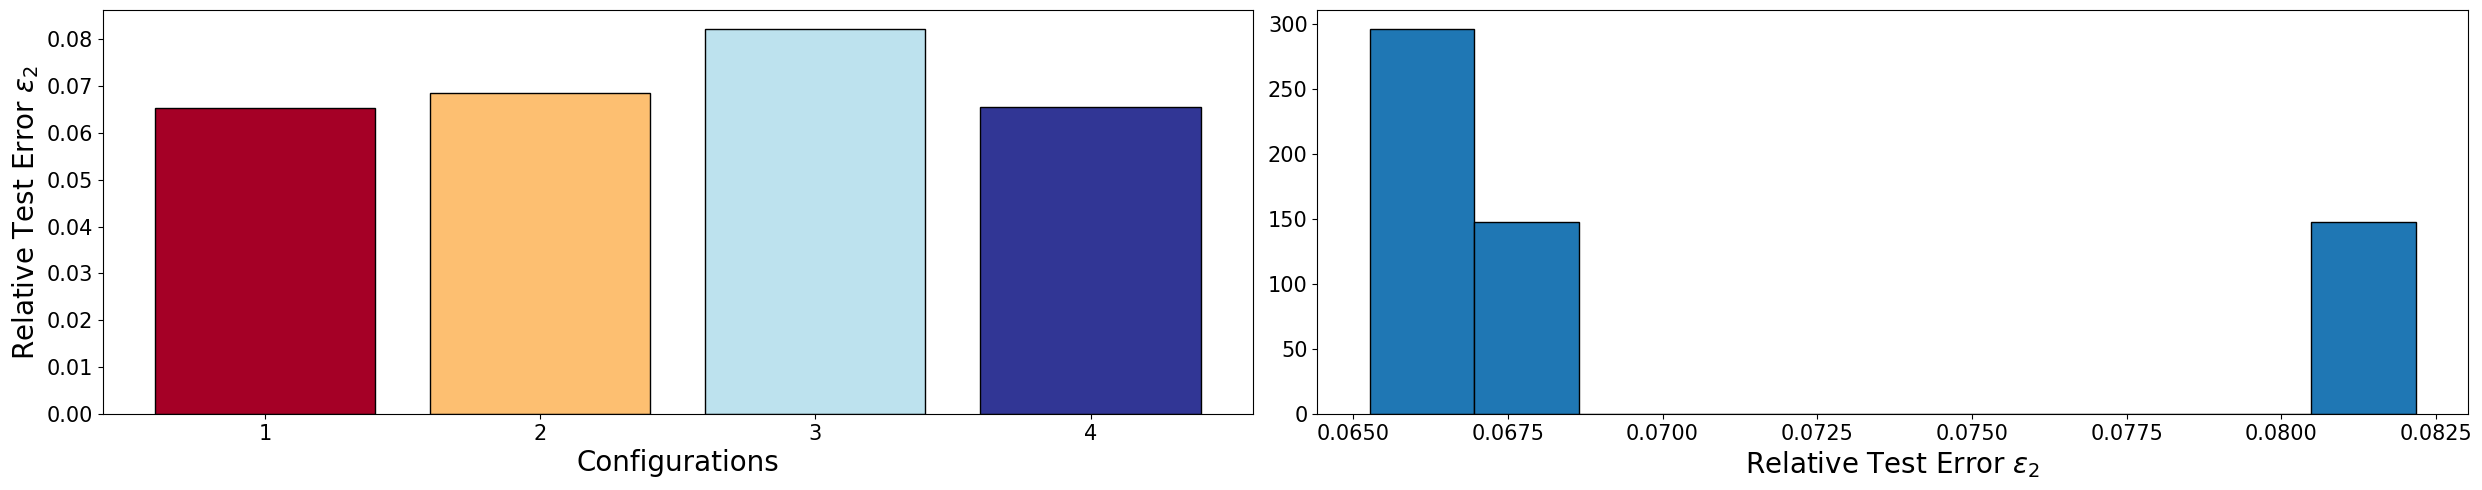

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25,5))

# Bars
axs[0].bar(np.arange(1, n_configurations+1, 1), relative_test_errors, 
        color = cm.RdYlBu(np.linspace(0,1,len(relative_test_errors))),
        edgecolor='k')

axs[0].set_xticks(np.arange(1, n_configurations+1, 1))
axs[0].set_xlabel(r'Configurations', fontsize=20)
axs[0].set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=20)

# Histogram
axs[1].hist(relative_test_errors, edgecolor='k', density=True)
axs[1].set_xlabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=20)

[ax.tick_params(axis='both', labelsize=15) for ax in axs]

plt.tight_layout()

In [22]:
time_test_indices = test_datasets[0]['full_idx']['test'].reshape(len(param_train_indices), -1)[0]

reshaped_test_recons = [rec.reshape((len(param_train_indices), time_test_indices.shape[0], -1)) for rec in test_recons]
reshaped_test_ground_truth = [truth.reshape((len(param_train_indices), time_test_indices.shape[0], -1)) for truth in test_ground_truth]

# step_time_test = np.array([new_t[-1] * ii for ii in range(len(param_train_indices))])
# plotting_time_test = np.array([new_t[lags+time_test_indices] + step for step in step_time_test])

### Decoding to Full Order
Let us compute the average relative error for generic field $u$ as
\begin{equation*}
\varepsilon_u = \frac{1}{T}\sum_{t=1}^T \frac{\| u_t - \hat{u}_t\|_2}{\| u_t\|_2}
\end{equation*}
given $\hat{u}_t$ the reconstruction at time $t$.

In [23]:
Ns_test = test_recons[0].shape[0]

if train_net:
    ave_rel_errors = np.zeros((Nvariables, Ns_test, n_configurations))

    for field_i in range(Nvariables):
        
        for kk in range(n_configurations):
            v_truth = test_ground_truth[kk][:, num_sensors + num_param + sum(Nmodes[:field_i]) : num_sensors + num_param + sum(Nmodes[:field_i+1])]
            v_shred = test_recons[kk][:,       num_sensors + num_param + sum(Nmodes[:field_i]) : num_sensors + num_param + sum(Nmodes[:field_i+1])]

            u_ = u_total[var_names[field_i]]
            s_ = np.diag(s_total[var_names[field_i]])

            fom = rescaling_snaps[field_i].inverse_transform(u_ @ s_ @ v_truth.T)
            prediction = rescaling_snaps[field_i].inverse_transform(u_ @ s_ @ v_shred.T)
            
            ave_rel_errors[field_i, :, kk] = np.linalg.norm(fom - prediction, axis=0) / np.linalg.norm(fom, axis=0)
            
    pickle.dump(ave_rel_errors, open(path_test+'fom.errors', 'wb'))
    
else:
    ave_rel_errors = pickle.load(open(path_test+'fom.errors', 'rb'))

Let us plot the errors using bar plots

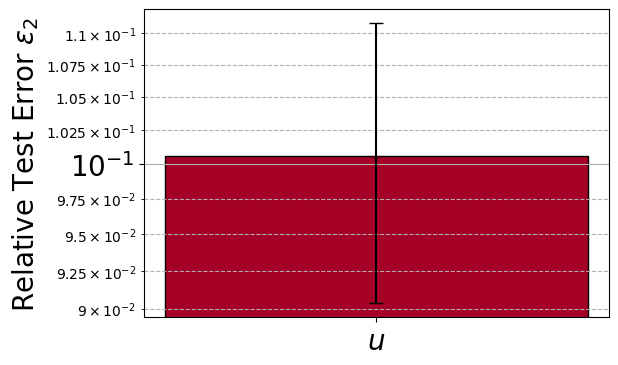

In [24]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(6,4))

colors = cm.jet(np.linspace(0,1, len(var_names)))
for field_i in range(len(var_names)):
    # axs.scatter(field_i , np.mean(ave_rel_errors.mean(axis=1), axis=1)[field_i], color=colors[field_i])
    axs.bar(np.arange(1, len(var_names)+1, 1), np.mean(ave_rel_errors.mean(axis=1), axis=1), 
            yerr = np.std(ave_rel_errors.mean(axis=1), axis=1), capsize=5,
            color = cm.RdYlBu(np.linspace(0,1,len(var_names))),
            edgecolor='k')

axs.set_yscale('log')
axs.set_xticks(np.arange(1,len(var_names)+1,1), ['$'+tex_+'$' for tex_ in tex_var_names])
# axs.set_yticks(np.arange(0,0.1,0.01))

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=20)
axs.grid(axis='y', linestyle='-')
axs.grid(axis='y', which='minor', linestyle='--')

fig.savefig(path_test+'fom_relativerrror_bars.pdf', format='pdf', dpi=250, bbox_inches='tight')

### Test Error on unknown parameter

Let us extract the test snapshots

In [25]:
param_to_test = test_datasets[0]['param_idx']['test'] # they are the same for other config
# param_to_test = test_datasets[0]['param_idx']['train'] # they are the same for other config

test_snaps = {
    field: [snaps['snapshots'][field][ii] for ii in param_to_test]
    for field in var_names
}
fom_times = snaps['t']

Nparam_test = len(param_to_test)

Let us create the measurements

In [26]:
test_measurements = np.zeros((Nparam_test, num_sensors, len(fom_times), n_configurations))

for ii in range(Nparam_test):
    for kk in range(n_configurations):
        test_measurements[ii, :, :, kk] = test_snaps[var_names[measured_field]][ii][idx_sensor_locations[:,kk]]

Let add noise

In [27]:
Xsensor = test_measurements + np.random.normal(scale=noise_value, size=test_measurements.shape)

**SHRED reconstruction**: Let us used the trained networks to reconstruct the snapshots for an unknown parameter

In [28]:
test_recons_new_dataset = list()

for ii in range(Nparam_test):
    
    test_recons_new_dataset.append(list())

    for kk in range(n_configurations):
        
        # Define scaler
        sc = test_datasets[kk]['scaler']

        _dummy_load_X = np.zeros((Xsensor[ii].shape[1], sum(Nmodes)+num_param)) # this is required by the scaler: it needs the input to be N x (sum(Nmodes) + num_sens)
        load_X = np.hstack((Xsensor[ii,:,:,kk].T, _dummy_load_X))

        transformed_X = sc.transform(load_X)

        # Generate test input sequences to a SHRED model
        all_data_in = np.zeros((len(fom_times) - lags, lags, num_sensors))
        for i in range(len(all_data_in)):
            all_data_in[i] = transformed_X[i:i+lags, sensor_locations]
        
        test_data_in = torch.tensor(all_data_in, 
                                    dtype=torch.float32).to(device)
        
        # Reconstruction
        test_recons_new_dataset[ii].append( sc.inverse_transform(shred[kk](test_data_in).detach().cpu().numpy()))

Let us extract the SVD reduced coefficients

In [29]:
param_shred = dict()
v_shred = dict()
v_svd   = dict()


for field_i in range(len(var_names)):
    
    param_shred[var_names[field_i]] = list()
    v_shred[var_names[field_i]] = list()
    v_svd[var_names[field_i]] = list()

    u_ = u_total[var_names[field_i]]
    s_ = np.diag(s_total[var_names[field_i]])

    for ii in range(Nparam_test):
        
        param_shred[var_names[field_i]].append(list())
        v_shred[var_names[field_i]].append(list())

        for kk in range(n_configurations):

            # SHRED
            param_shred[var_names[field_i]][ii].append(test_recons_new_dataset[ii][kk][:, num_sensors])
            v_shred[var_names[field_i]][ii].append(test_recons_new_dataset[ii][kk][:, num_sensors + num_param + sum(Nmodes[:field_i]) : num_sensors + num_param + sum(Nmodes[:field_i+1])])
            
            
        # SVD
        v_svd[var_names[field_i]].append(   np.linalg.solve(s_, 
                                                            u_.T @ rescaling_snaps[field_i].transform(test_snaps[var_names[field_i]][ii])
                                                            )
                                        )
        
        param_shred[var_names[field_i]][ii] = np.array(param_shred[var_names[field_i]][ii])

Let us decode the SVD

In [30]:
prediction_svd = dict()

for field_i in range(len(var_names)):

    u_ = u_total[var_names[field_i]]
    s_ = np.diag(s_total[var_names[field_i]])
        
    prediction_svd[var_names[field_i]] = list()
    
    for ii in range(Nparam_test):
        prediction_svd[var_names[field_i]].append(rescaling_snaps[field_i].inverse_transform(u_ @ s_ @ v_svd[var_names[field_i]][ii])) 

Let us compute decode the SHRED to the full order space

In [31]:
prediction = dict()
std_dev_prediction = dict()

for field_i in range(len(var_names)):
    
    u_ = u_total[var_names[field_i]]
    s_ = np.diag(s_total[var_names[field_i]])
        
    prediction[var_names[field_i]] = list()
    std_dev_prediction[var_names[field_i]] = list()

    for ii in range(Nparam_test):

        shred_v_mean = np.asarray(v_shred[var_names[field_i]][ii]).mean(axis=0).T
        shred_v_std  = np.asarray(v_shred[var_names[field_i]][ii]).std(axis=0).T
    
        prediction[var_names[field_i]].append(rescaling_snaps[field_i].inverse_transform(u_ @ s_ @ shred_v_mean) )
        std_dev_prediction[var_names[field_i]].append(rescaling_snaps[field_i].inverse_std_transform(u_ @ s_ @ shred_v_std))

Contour plots are generated

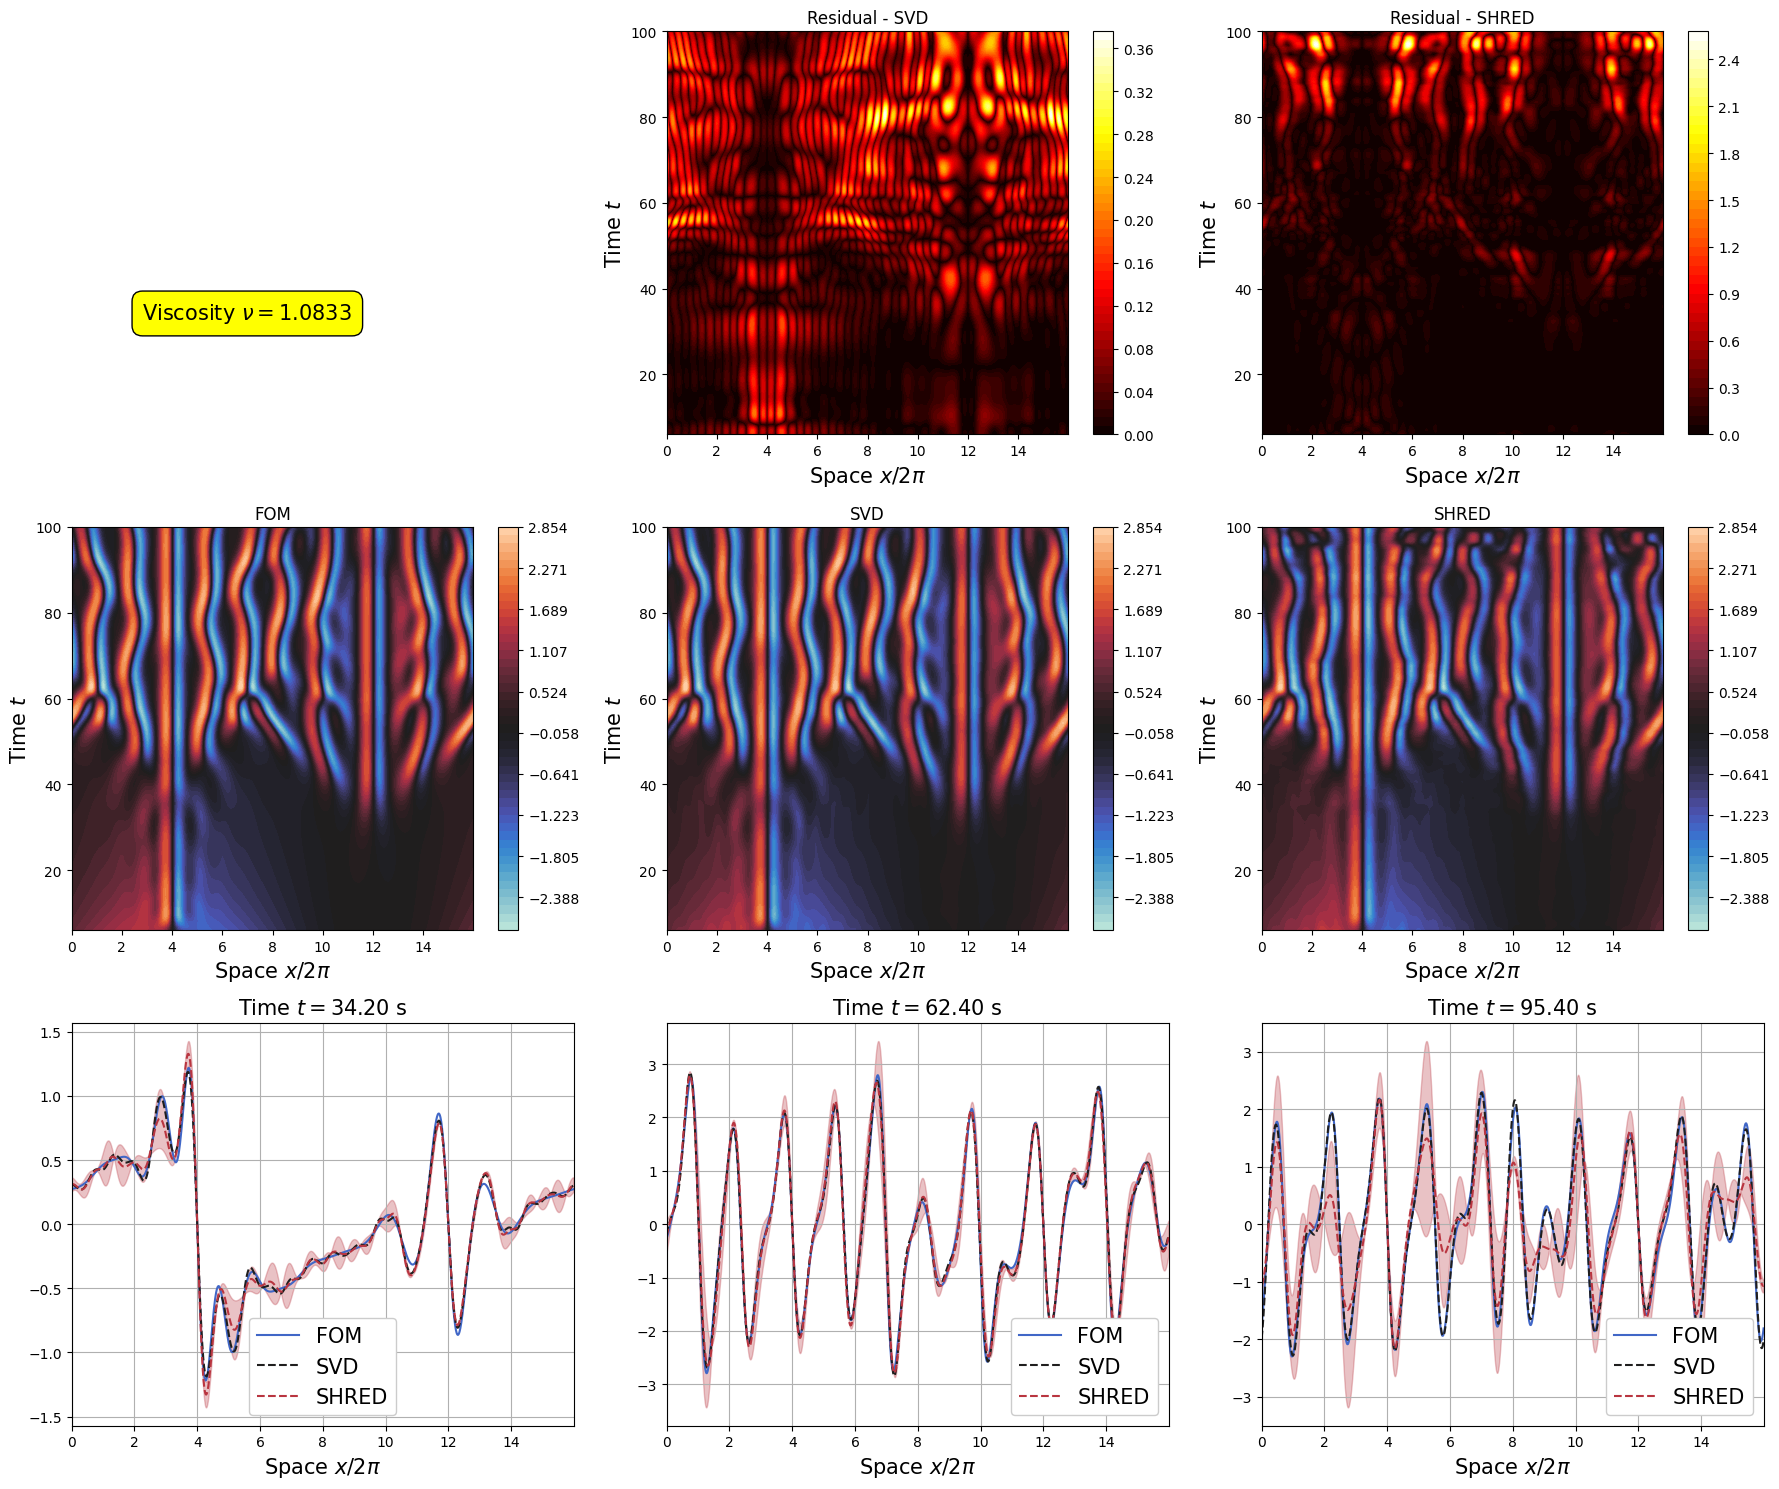

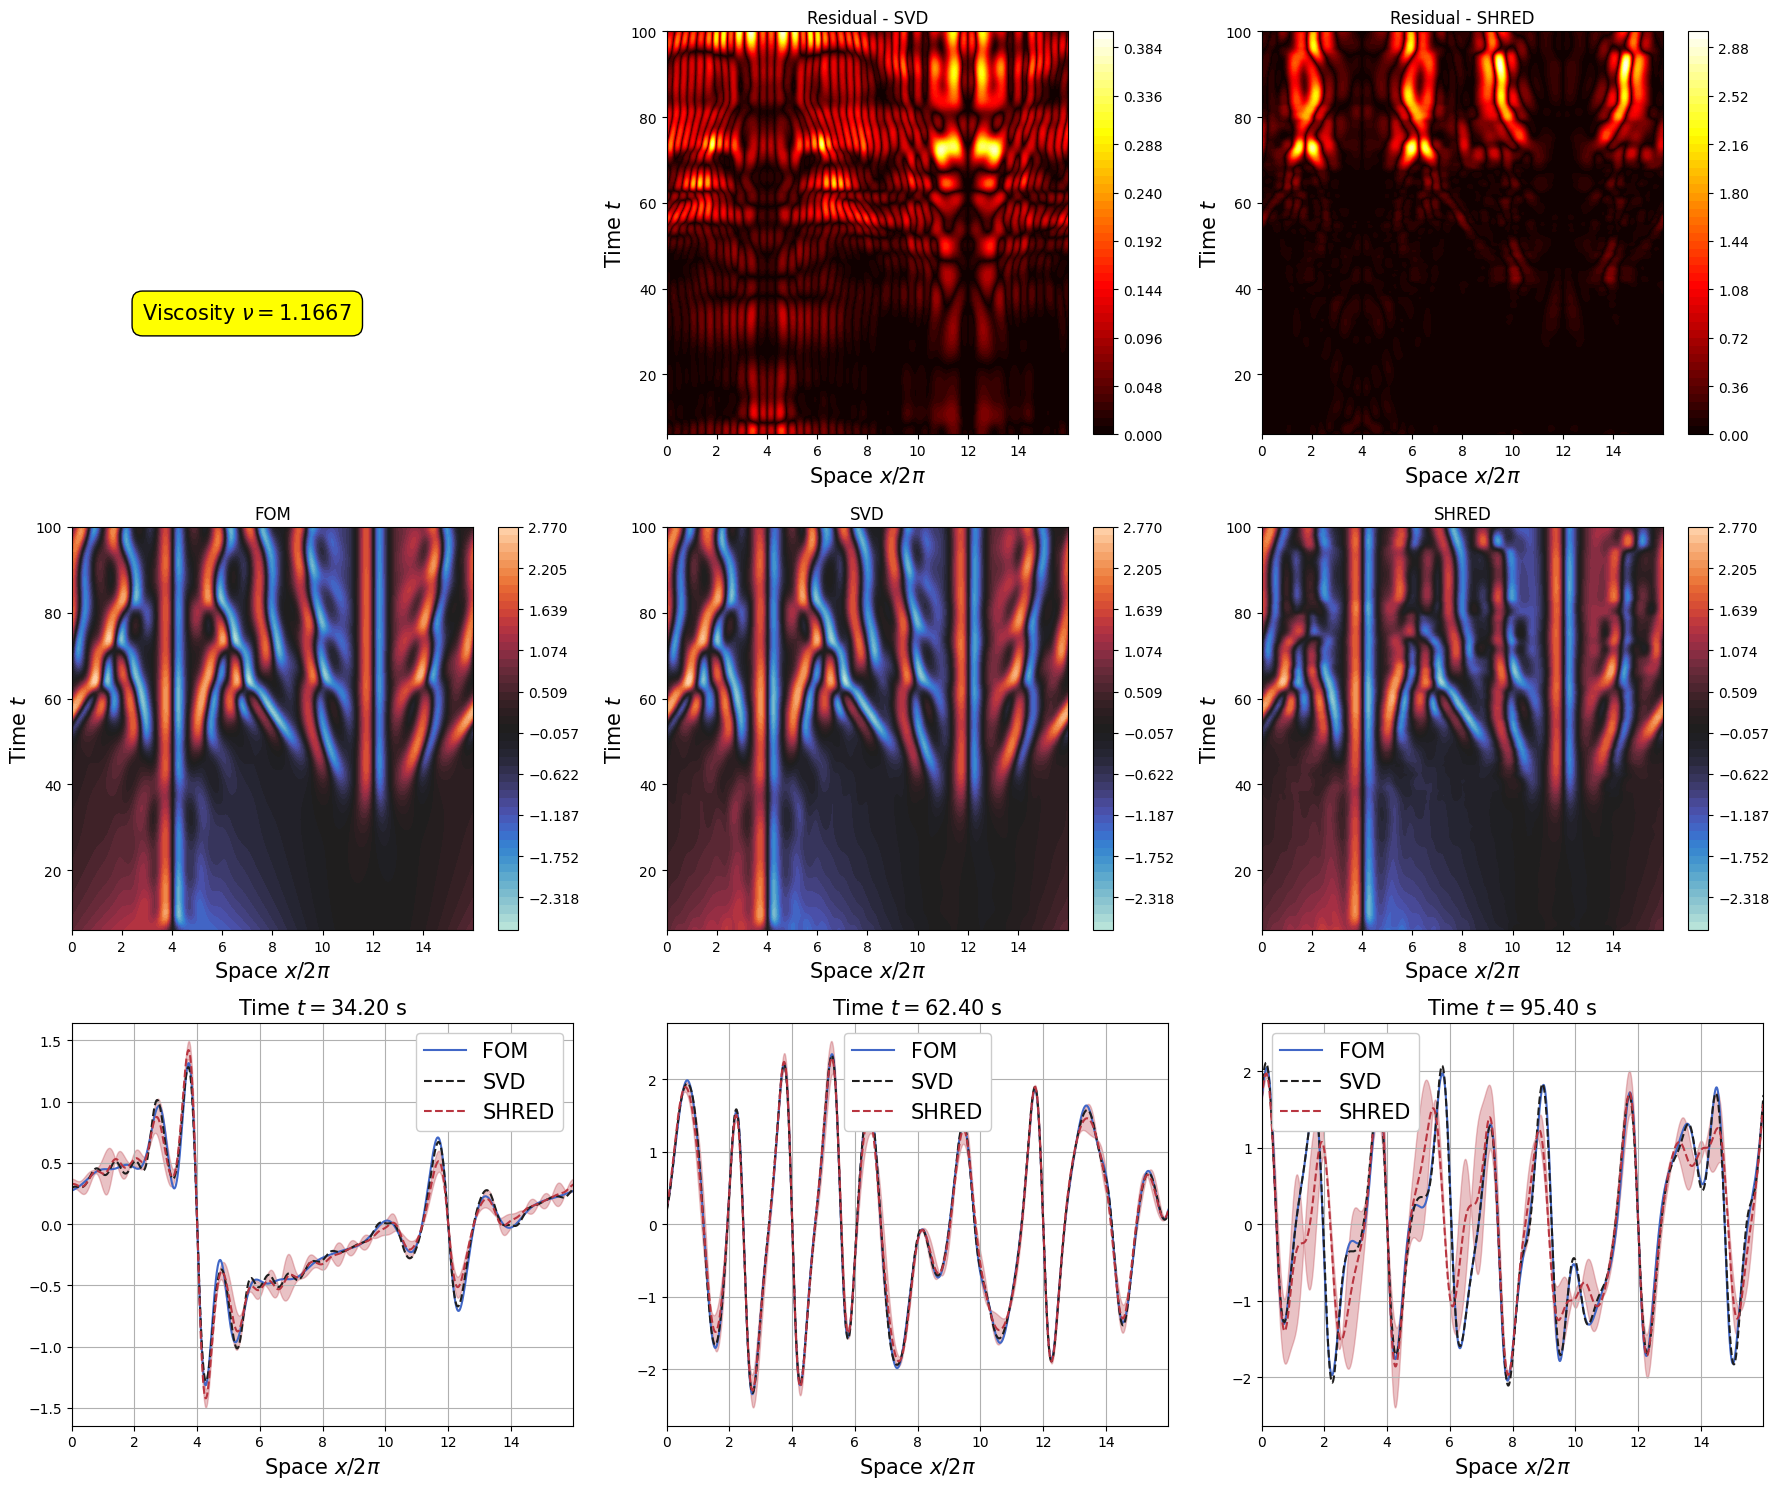

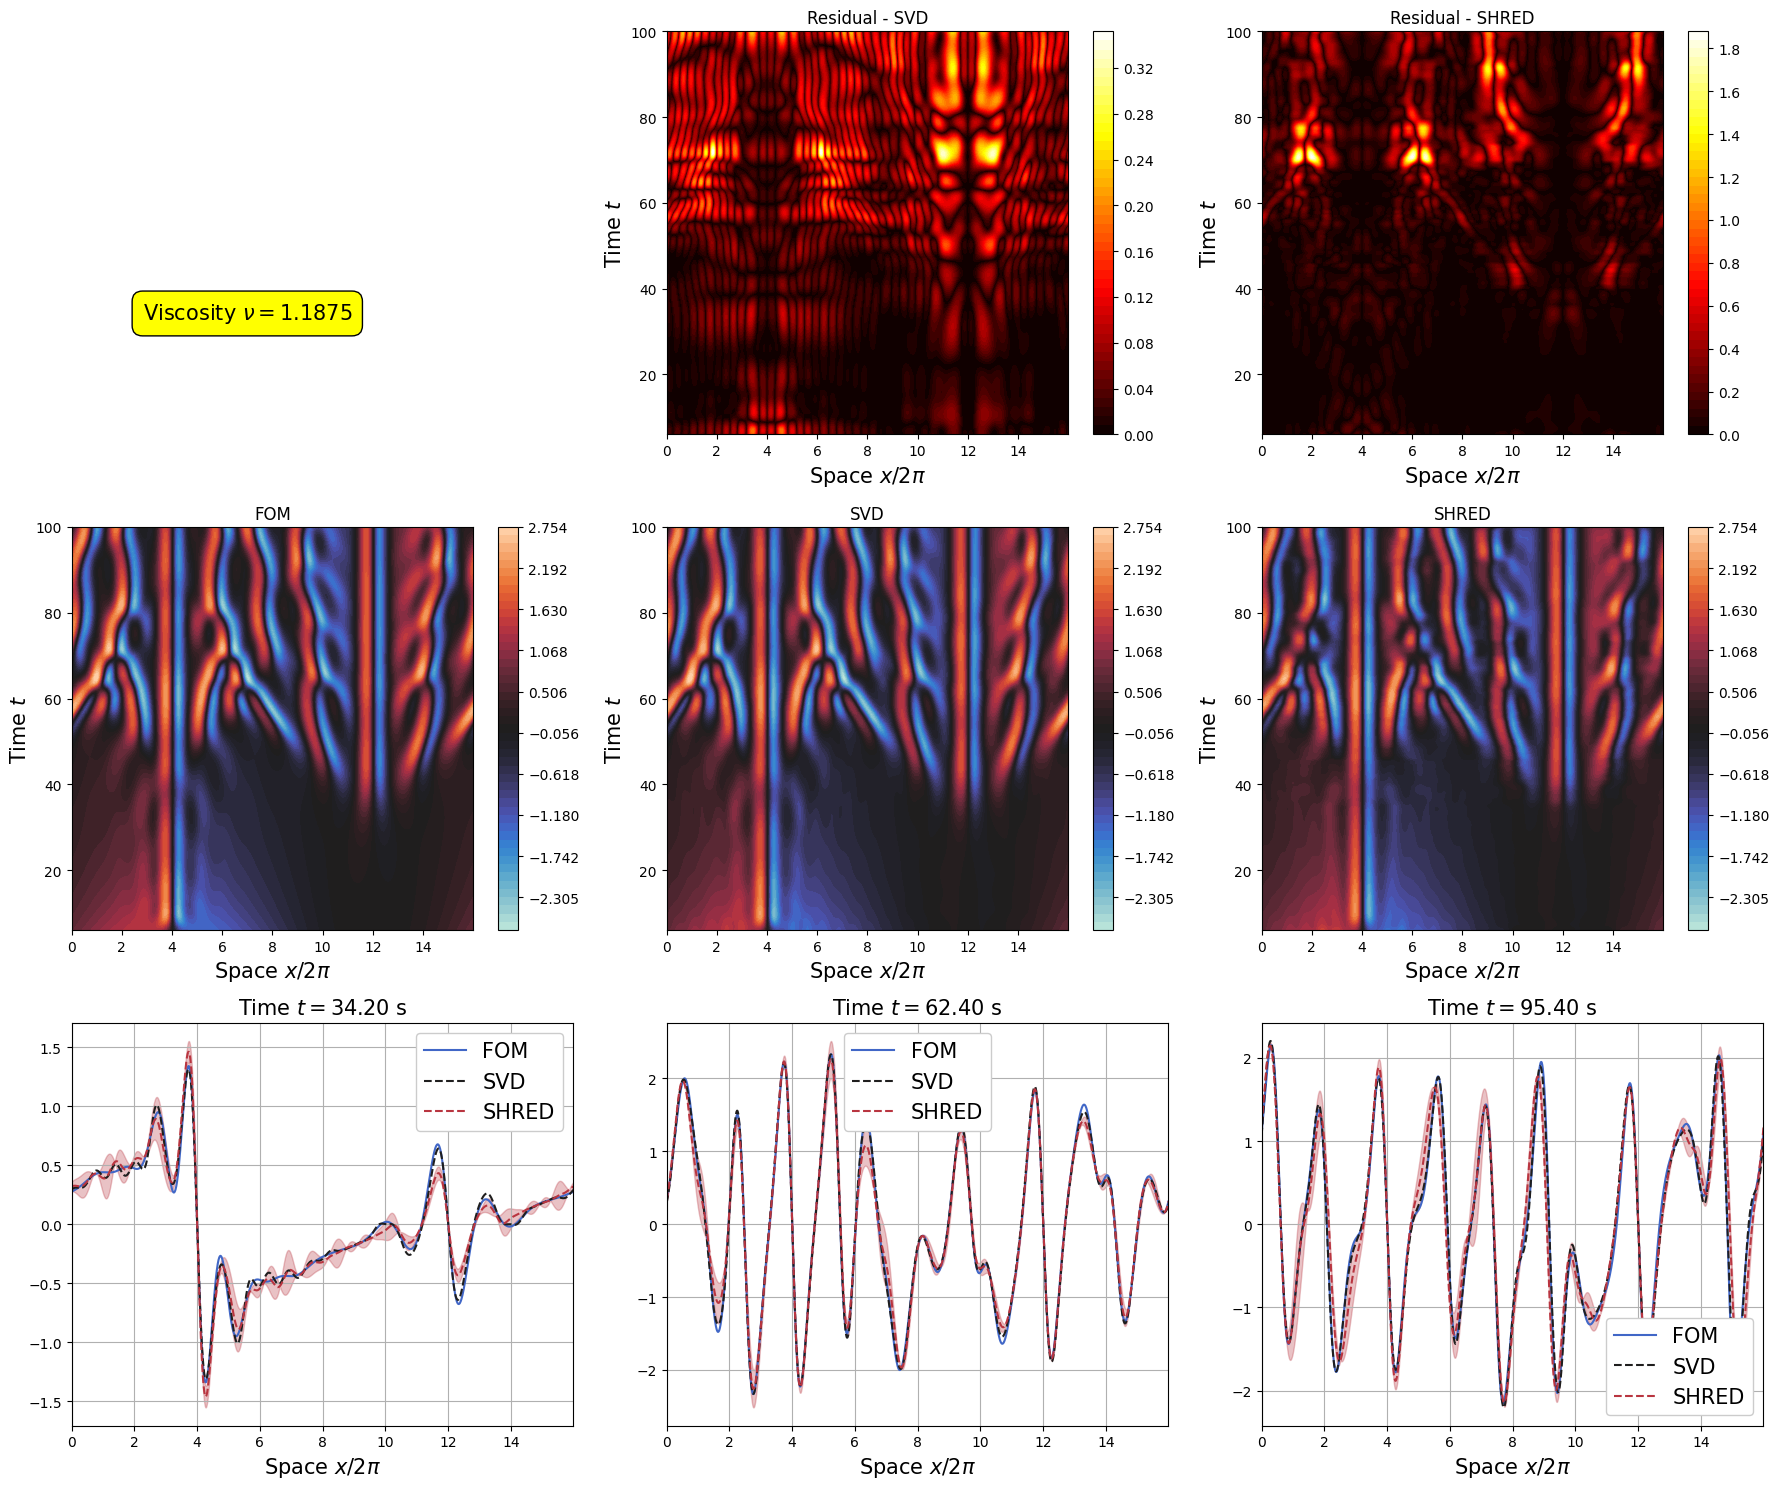

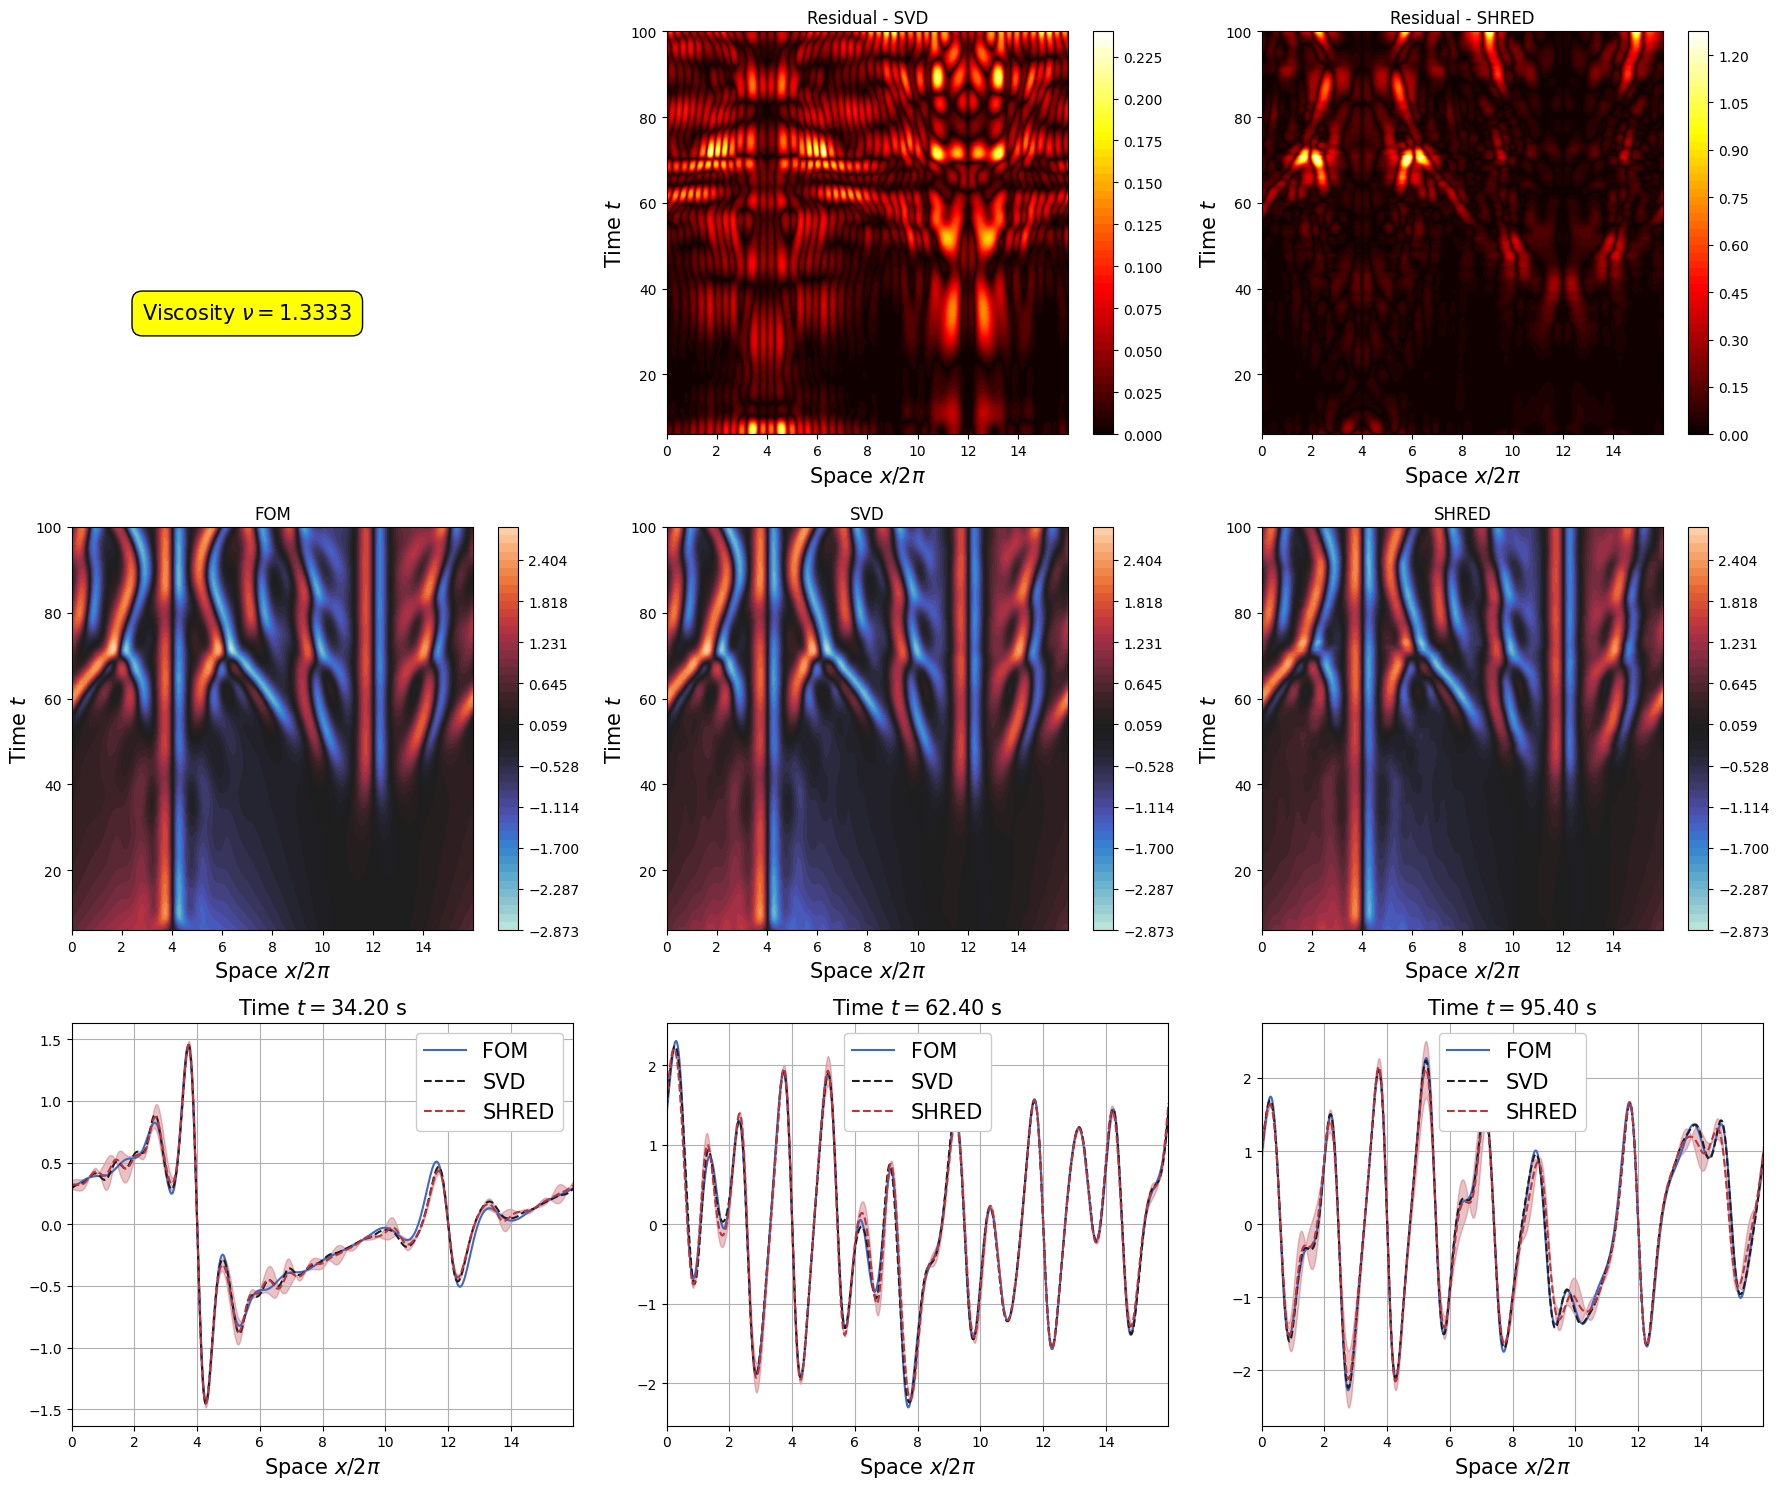

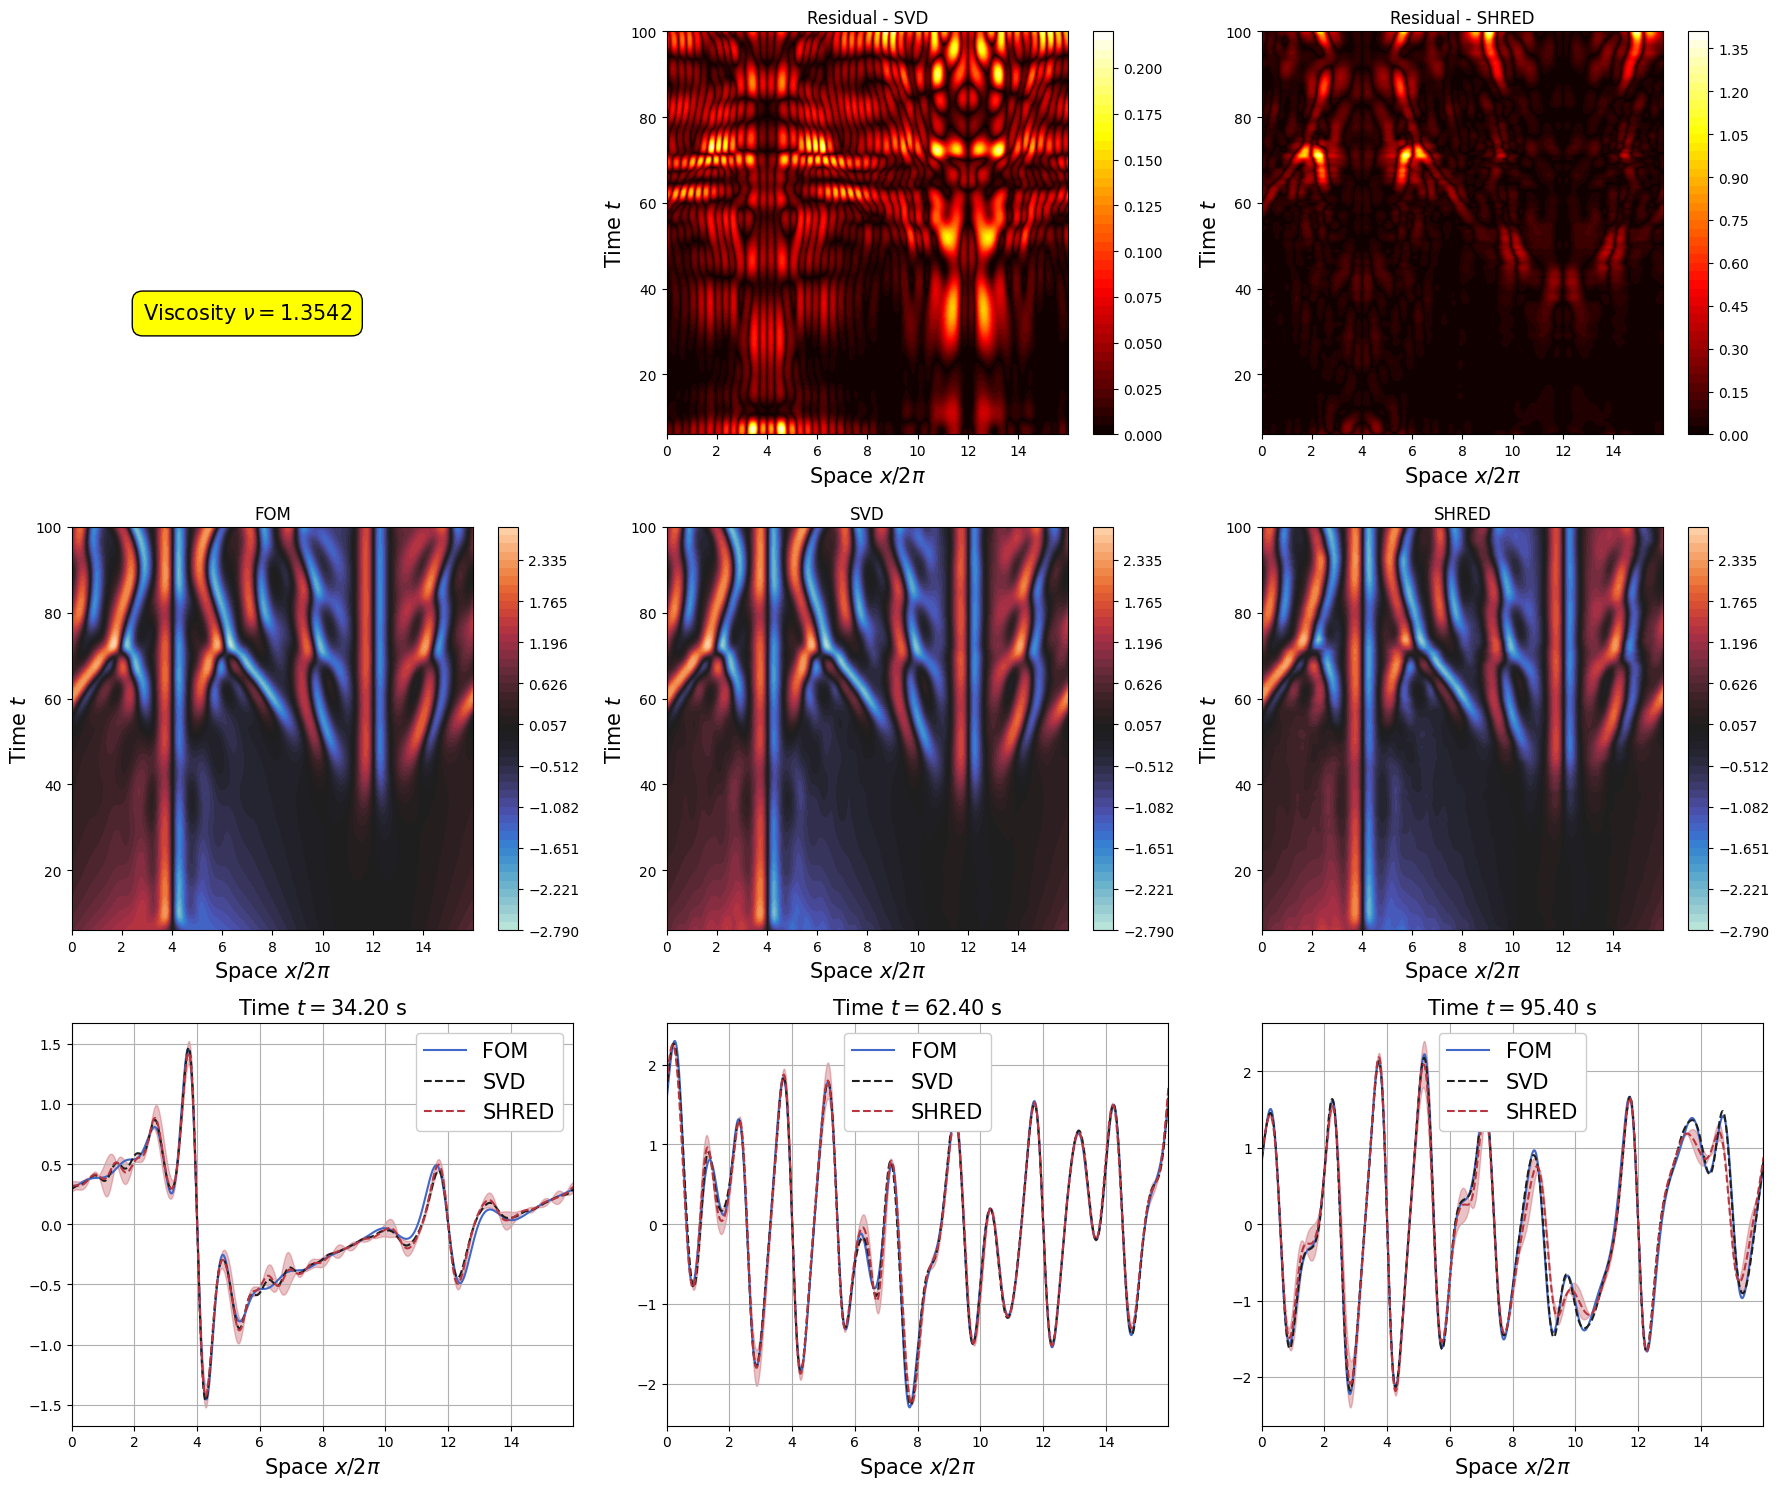

In [32]:
from plots import plot_FOM_vs_Recon

field_i = 0
field = var_names[field_i]

for param_ii_to_plot in range(Nparam_test):

    recons = {'SVD': prediction_svd[var_names[field_i]][param_ii_to_plot][:, lags:], 
            'SHRED': prediction[var_names[field_i]][param_ii_to_plot]}
    std_recons = {'SVD': None, 
                'SHRED': std_dev_prediction[var_names[field_i]][param_ii_to_plot]}

    plot_FOM_vs_Recon(domain, fom_times[lags:], 
                    test_snaps['u'][param_ii_to_plot][:, lags:], recons, 
                    std_recons = std_recons,
                    time_idx = [0.3, 0.6, 0.95],
                    #filename = path_fig+'Recons_nu'+save_str+'_{:.2f}_'.format(folder_list[param_to_reconstruct[fold_i],0])+field,
                    format = 'png', nlevels=50,
                    box = r'Viscosity $\nu = {:.4f}$'.format(params[param_to_test[param_ii_to_plot]])
                    )